In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import os, math
import random
import numpy as np
from create_paths import smoothen_paths

In [2]:
# 3 input channels (noise, map, initial path)
class Generator(nn.Module):
    def __init__(self, features, device='cpu'):
        super(Generator, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, features, 5, 1, 2, device=device),
            nn.ReLU()
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(features, features*2, 5, 1, 2, device=device),
            nn.InstanceNorm2d(features*2, affine=True, device=device),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn. Conv2d(features*2, features, 5, 1, 2, device=device),
            nn.InstanceNorm2d(features, affine=True, device=device),
            nn.ReLU()
        )

        self.block4 = nn.Sequential(
            nn. Conv2d(features, 1, 5, 1, 2, device=device),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.block1(x)
        y = self.block2(y)
        y = self.block3(y)
        y = self.block4(y)

        # y = F.adaptive_max_pool2d(y, output_size=map_shape)

        y = self._round(y)
        return y
    
    def _round(self, mat):
        # TODO: cite something? (this function is based off of Thor's code)
        mat_hard = torch.round(mat)
        mat = (mat_hard - mat.data) + mat

        return mat


In [3]:
# Need to override __init__, __len__, __getitem__
# as per datasets requirement
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path_dir, map_file, transform=None, shape = (100,100), device='cpu'):
        self.device = device
        self.paths = [] # create a list to hold all paths read from file
        self.map = np.loadtxt(map_file, skiprows=2).reshape(shape)
        self.map = self.map[np.newaxis, :, :]
        for filename in os.listdir(path_dir):
            with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=int).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                self.path_matrix = self.convert_path(shape, self.path)
                
                self.paths.append(self.path_matrix) # add the path to paths list
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir
            
        path_mat[path[path.shape[0]-1,1], path[path.shape[0]-1,0]] = 1     # Include the last point in the path

        


        # Add Initial Path onto the loaded path matrix
        initial_path = np.zeros_like(path_mat)

        # Create Straight line between start/end points
        x1 = path[0,0]
        y1 = path[0,1]
        x2 = path[path.shape[0]-1,0]
        y2 = path[path.shape[0]-1,1]

        x = x1
        y = y1

        if (x1 < x2):
            x_dir = 1
        else:
            x_dir = -1

        if (y1 < y2):
            y_dir = 1
        else:
            y_dir = -1

        # Determine y from x
        if x2-x1 != 0:
            m = (y2-y1)/(x2-x1)
            while x != x2:
                y = round(m*(x-x1) + y1)
                initial_path[y,x] = 1
                x += x_dir
        else:
            while x != x2:
                initial_path[y1,x] = 1
                x += x_dir

        x = x1
        y = y1
        # Determine x from y
        if y2-y1 != 0:
            m = (x2-x1)/(y2-y1)
            while y != y2:
                x = round(m*(y-y1) + x1)
                initial_path[y,x] = 1
                y += y_dir
        else:
            while y != y2:
                initial_path[y,x1] = 1
                y += y_dir

        path_mat = np.stack((path_mat, initial_path))

        return path_mat

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = np.float32(self.paths[idx])
        x = torch.Tensor(x).to(self.device)

        if self.transform:
            x = self.transform(x)
        
        return x

        #return image, label

In [4]:
transforms = tfms.Compose(
    [
        # tfms.ToTensor(),
        # tfms.Normalize(
        #     [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        # ),
    ]
)

In [5]:
# Inputs
MAP_NAME = 'map_64x64'
MAP_SHAPE = (64,64)
# MAP_NAME = '8x12_map'
# MAP_SHAPE = (163,243)
START = (10,10)
GOAL = (55,55)

NUM_EXAMPLES = 5

GEN_PATH = './checkpoints/wgan_gp/generator_test/epoch-0.pt'
LOAD_EPOCH = 0  # The epoch checkpoint to load

# # Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = 50

NOISE_SHAPE = (INPUT_SIZE, 1, MAP_SHAPE[0], MAP_SHAPE[1])

In [6]:
# open map file:
map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2).reshape(MAP_SHAPE)
map = map[np.newaxis,np.newaxis,:,:]
map = np.repeat(map, INPUT_SIZE, axis=0)
map = torch.Tensor(map).to(device)

In [7]:
gen = torch.load(GEN_PATH)
gen.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
  )
  (block4): Sequential(
    (0): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
  )
)

In [8]:
test_dataset = PathsDataset(path_dir = f"./env/{MAP_NAME}/paths/good_paths", map_file = f"./env/{MAP_NAME}/{MAP_NAME}.txt", shape = MAP_SHAPE, transform=transforms, device=device)
dataloader_test = DataLoader(test_dataset, batch_size=INPUT_SIZE, shuffle=True, drop_last=True)

Done!


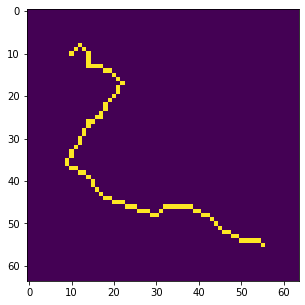

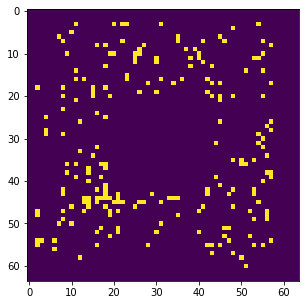

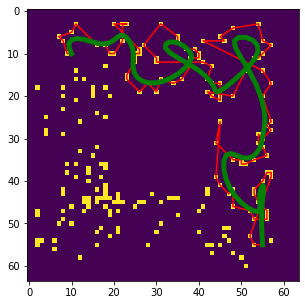

TypeError: list indices must be integers or slices, not tuple

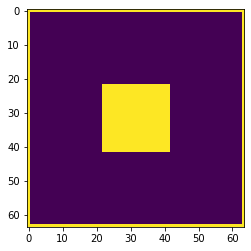

In [9]:
count = 0

for batch_idx, real in enumerate(dataloader_test):

    if count == NUM_EXAMPLES:
        break

    initial_path = real[:,1:2,:,:]
    rrt_path = real[:,0:1,:,:]
    noise = torch.randn(NOISE_SHAPE, device=device)
    noise = torch.concat((noise, initial_path, map), axis=1)
    
    result = gen(noise).cpu().detach().numpy()[0][0].tolist()

    # display original rrt star path:
    plt.figure(figsize=(5,5))
    plt.imshow(rrt_path[0][0].cpu())
    plt.show()

    # display what the generator created:
    plt.figure(figsize=(5,5))
    plt.imshow(result)
    plt.show()

    # display connected path:
    smooth_paths = smoothen_paths([result], START, GOAL, figsize=(5,5), display=True)

    plt.imshow(map.cpu()[0][0])
    plt.plot(smooth_paths[:,0], smooth_paths[:,1])
    plt.show()

    count += 1
    